In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2022-06-21 15:20:56.701864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 15:20:56.701932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data preparation

 As the Kaggle entry states, the folder 'dataset2-master' contains 2,500 augmented images with 4 additional subtype labels (JPEG + CSV).

In [2]:
# Make path variable and determine desired image dimensions
test_path = r'/homes/maschepers/Documents/Cell_data_DeepLearning/dataset2-master/dataset2-master/images/TEST/'
train_path = r'/homes/maschepers/Documents/Cell_data_DeepLearning/dataset2-master/dataset2-master/images/TRAIN/'

train_data = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator = train_data.flow_from_directory(
    directory=train_path,
    batch_size=20,
    color_mode='rgb',
    target_size=(120, 160),
    class_mode='categorical'
)

test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_data.flow_from_directory(
    directory=test_path,
    batch_size=20,
    color_mode='rgb',
    target_size=(120, 160),
    class_mode='categorical'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [3]:

def get_data(generator, batch_size):
    # Store the data in X, y variables by iterating over the batches
    generator.reset()
    X, y = next(generator)
    for i in range(int(len(generator)/batch_size)-1): #1st batch is already fetched before the for loop.
        img, label = next(generator)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    print(X.shape, y.shape)
    return X, y

# A subset of the data will be used as to not overload these models
X_train, y_train = get_data(train_generator, 2)
X_test, y_test = get_data(test_generator, 2)

y_train

(4980, 120, 160, 3) (4980, 4)
(1240, 120, 160, 3) (1240, 4)


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Deep learning model creation

In [18]:
# create model
neural = keras.models.Sequential()

neural.add(keras.layers.InputLayer(input_shape=(120, 160, 3), name='Input'))
neural.add(keras.layers.Flatten())
neural.add(keras.layers.Dense(units=128, activation='LeakyReLU', name='Hidden_1'))
neural.add(keras.layers.Dense(units=64, activation='LeakyReLU', name='Hidden_2'))
# neural.add(keras.layers.Dropout(0.3))
neural.add(keras.layers.Dense(units=32, activation='LeakyReLU', name='Hidden_3'))
neural.add(keras.layers.Dropout(0.3))
neural.add(keras.layers.Dense(units=4, activation='softmax', name='Output'))

neural.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 57600)             0         
                                                                 
 Hidden_1 (Dense)            (None, 128)               7372928   
                                                                 
 Hidden_2 (Dense)            (None, 64)                8256      
                                                                 
 Hidden_3 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 4)                 132       
                                                                 
Total params: 7,383,396
Trainable params: 7,383,396
No

In [19]:
neural.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),  # learning_rate=1e-6
    metrics=keras.metrics.CategoricalAccuracy()
)

In [20]:
history = neural.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    batch_size=250,
    verbose=1,
    validation_data=(X_test, y_test)  # np.random.shuffle(y_test)
)

history.history.keys()

Epoch 1/30


2022-06-21 15:29:16.849745: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1147392000 exceeds 10% of free system memory.


20/20 [==============================] - 2s 102ms/step - loss: 25.2836 - categorical_accuracy: 0.2532 - val_loss: 2.2128 - val_categorical_accuracy: 0.2460
Epoch 2/30
20/20 [==============================] - 2s 91ms/step - loss: 6.7497 - categorical_accuracy: 0.2472 - val_loss: 1.8852 - val_categorical_accuracy: 0.2589
Epoch 3/30
20/20 [==============================] - 2s 92ms/step - loss: 3.8182 - categorical_accuracy: 0.2494 - val_loss: 2.1975 - val_categorical_accuracy: 0.2532
Epoch 4/30
20/20 [==============================] - 2s 89ms/step - loss: 2.3050 - categorical_accuracy: 0.2578 - val_loss: 2.5041 - val_categorical_accuracy: 0.2540
Epoch 5/30
20/20 [==============================] - 2s 88ms/step - loss: 2.1873 - categorical_accuracy: 0.2562 - val_loss: 1.6653 - val_categorical_accuracy: 0.2379
Epoch 6/30
20/20 [==============================] - 2s 88ms/step - loss: 2.3376 - categorical_accuracy: 0.2516 - val_loss: 1.4475 - val_categorical_accuracy: 0.2524
Epoch 7/30
20/20 [=

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

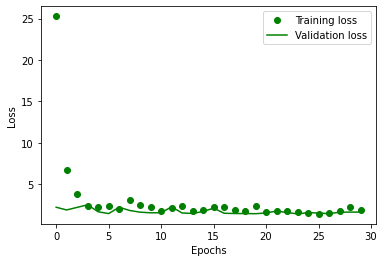

In [23]:
plt.plot(history.history['loss'], 'go', label='Training loss')
plt.plot(history.history['val_loss'], 'g-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

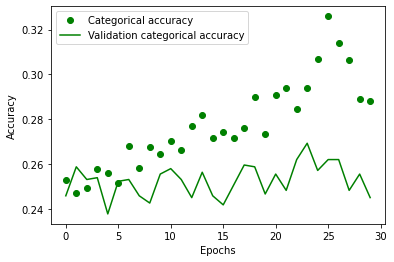

In [24]:
plt.plot(history.history['categorical_accuracy'], 'go', label='Categorical accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'g-', label='Validation categorical accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()